visualize prediction performance

---

In [1]:
import glob, sys

In [2]:
import scipy as sp
import pandas as pd
import palettable
import seaborn as sns
sns.set_context(context="paper", font_scale=1.5)
sns.set_style(style='white')
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
def read_data_bm(data_name, bm_dir):
    result_file_list = [f for f in glob.glob(bm_dir+'{}-*.csv'.format(data_name)) if not f.endswith('rankings.csv')]
    data_bm_df = pd.DataFrame()
    for result_file in result_file_list:
        clf_bm_df = pd.read_csv(result_file, index_col=0)
        clf_bm_df['clf'] = result_file.split('-')[-1][:-4]
        #print(clf_bm_df)
        clf_bm_df['data_name'] = data_name
        data_bm_df = data_bm_df.append(clf_bm_df.copy(), ignore_index=True)
    ## try to convert clf names
    rf_trim_name_list = pd.np.sort(data_bm_df.clf[data_bm_df.clf.str.contains('trimmed')].unique())
    #print(data_name, rf_trim_name_list)
    rf_trim_convert_list = ['k', '2k']
    mapping = {rf_name: 'randomforest_'+rf_trim_convert_list[i] for i, rf_name in enumerate(rf_trim_name_list)}
    data_bm_df.clf[data_bm_df.clf.str.contains('trimmed')] = data_bm_df.clf[data_bm_df.clf.str.contains('trimmed')].map(mapping)
    return data_bm_df

In [4]:
def do_model_compare(data_list, metric_list, 
                     bm_dir, s3d_dir, type_='classification',
                     color_list=None, fp_kwargs={},
                     #metric_list=['accuracy', 'f1_micro', 'f1_binary', 'auc_micro'],
                     #bm_dir = '../benchmark/cv-results/',
                     #s3d_dir = './',  color_list=None,
                     #fp_kwargs={},
                    ):
    col_list = metric_list + ['clf']
    ## read results
    bm_df = pd.DataFrame()
    s3d_df = pd.DataFrame()
    for i, data_name in enumerate(data_list):
        bm_df = bm_df.append(read_data_bm(data_name, bm_dir), ignore_index=True)
        _ = pd.read_csv(s3d_dir+data_name+'-test-performance.csv')
        _['data_name'] = data_name
        s3d_df = s3d_df.append(_, ignore_index=True)
    bm_df = bm_df[col_list+['data_name']]
    s3d_df['clf'] = 's3d'
    s3d_df = s3d_df[col_list+['data_name']]
    ## merge them
    all_df = bm_df.append(s3d_df, ignore_index=True)
    all_df = all_df.melt(id_vars=['clf', 'data_name'], value_vars=col_list[:-1])
    ## if regression, negate the values
    if type_ == 'regression':
        all_df['value'] = -all_df['value']
        mse_index = all_df[all_df.variable=='mse'].index.values
        all_df.loc[mse_index, 'value'] = pd.np.sqrt(all_df.loc[mse_index, 'value'])
        all_df.loc[mse_index, 'variable'] = 'rmse'
    
    #print(all_df)
    ## visualize
    g = sns.factorplot(x='variable', y='value', col='data_name', 
                       hue='clf', kind='bar', legend=False,
                       data=all_df.query("data_name in @data_list"), 
                       **fp_kwargs
                      )
    g.set_titles('{col_name}', size=14)
    g.set_xlabels('')
    g.set_ylabels('score', fontdict={'size': 14})
    if 'hue_order' in fp_kwargs:
        _ = g.add_legend(label_order=fp_kwargs['hue_order'])
    else:
        _ = g.add_legend()
    return g, all_df

name pair for datasets

In [5]:
import json
name_pair_dict = json.load(open("../data/name_pair.json"))
name_pair_dict

{'breastcancer': 'Breast Cancer (Diagnostic)',
 'spambase': 'Spambase',
 'spectf': 'SPECTF',
 'parkinsons': 'Parkinsons',
 'stackoverflow_cleaned_subset': 'Stack Exchange',
 'khan_cleaned': 'Khan',
 'digg': 'Digg',
 'twitter': 'Twitter',
 'duolingo_cleaned': 'Duolingo',
 'appenergy': 'App Energy',
 'building_sales': 'Building (Sales)',
 'building_costs': 'Building (Costs)',
 'pol': 'Pole',
 'breastcancer_reg': 'Breast Cancer (Prognostic)',
 'boston_housing': 'Boson Housing',
 'triazines': 'Triazines',
 'parkinsons_motor': 'Parkinsons (Motor)',
 'parkinsons_total': 'Parkinsons (Total)'}

In [37]:
color_list = pd.np.asarray(palettable.cartocolors.qualitative.Bold_7.mpl_colors)
color_list = color_list[[2,5,6,4,3,1,0]]

---

#### classification

In [38]:
type_ = 'classification'
data_list = [
             "breastcancer", "spambase", "spectf", "parkinsons",
             "stackoverflow_cleaned_subset", "khan_cleaned",
             "digg", "twitter", "duolingo_cleaned"
            ]
#metric_list=['accuracy', 'f1_binary', 'auc_micro']
metric_list=['accuracy', 'f1_micro', 'auc_micro']
fp_kwargs = {
             'col_wrap': 3,
             'aspect': 1.2,
             'alpha': .65,
             'palette': color_list,
             'hue_order': ['linearsvc', 'randomforest', 
                           'randomforest_2k', 'randomforest_k',
                           's3d', 'lasso', 'elasticnet',
                           ]
            }
legend_text = [ 'Linear SVM', 'RF', 'RF ($2k$)', 'RF ($k$)',
               'S3D', 'Lasso', 'Elastic Net',
              ]

/Users/zhiyzuo/.virtualenvs/Zuo-Py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


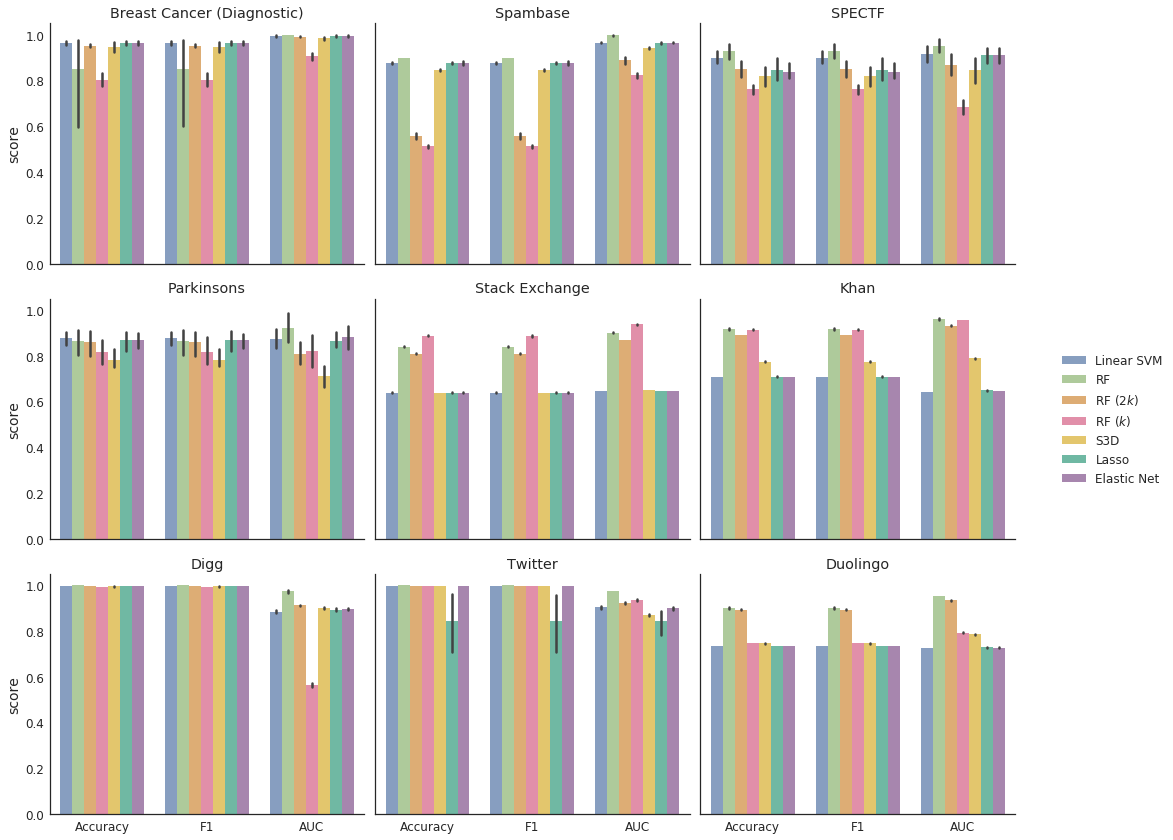

In [39]:
g, all_df = do_model_compare(data_list, metric_list, 
                             bm_dir='{}/bm-performance/'.format(type_), 
                             s3d_dir='{}/performance/'.format(type_),
                             fp_kwargs=fp_kwargs, 
                            )
g.set_xticklabels(['Accuracy', 'F1', 'AUC'])
for i, t in enumerate(g._legend.texts):
    t.set_text(legend_text[i])
for ax_i in g.axes:
    ax_i.set_title(name_pair_dict[ax_i.get_title()])

---

#### regression

In [40]:
type_ = 'regression'
data_list = ["appenergy", "building_sales", "building_costs",
             "pol", "breastcancer_reg",  
             "boston_housing", "triazines",
             "parkinsons_motor", "parkinsons_total",
            ]
metric_list=['mse', 'mae', 'mae_median']
fp_kwargs = {
             'col_wrap': 3,
             'aspect': 1.2,
             'alpha': .65,
             'palette': palettable.cartocolors.qualitative.Bold_7.mpl_colors,
             'sharey': False,
             'hue_order': ['linearsvr', 'randomforest', 
                           'randomforest_2k', 'randomforest_k',
                           's3d', 'lasso', 'elasticnet',
                           ]
            }
legend_text = [ 'Linear SVM', 'RF', 'RF ($2k$)', 'RF ($k$)',
               'S3D', 'Lasso', 'Elastic Net',
              ]

/Users/zhiyzuo/.virtualenvs/Zuo-Py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


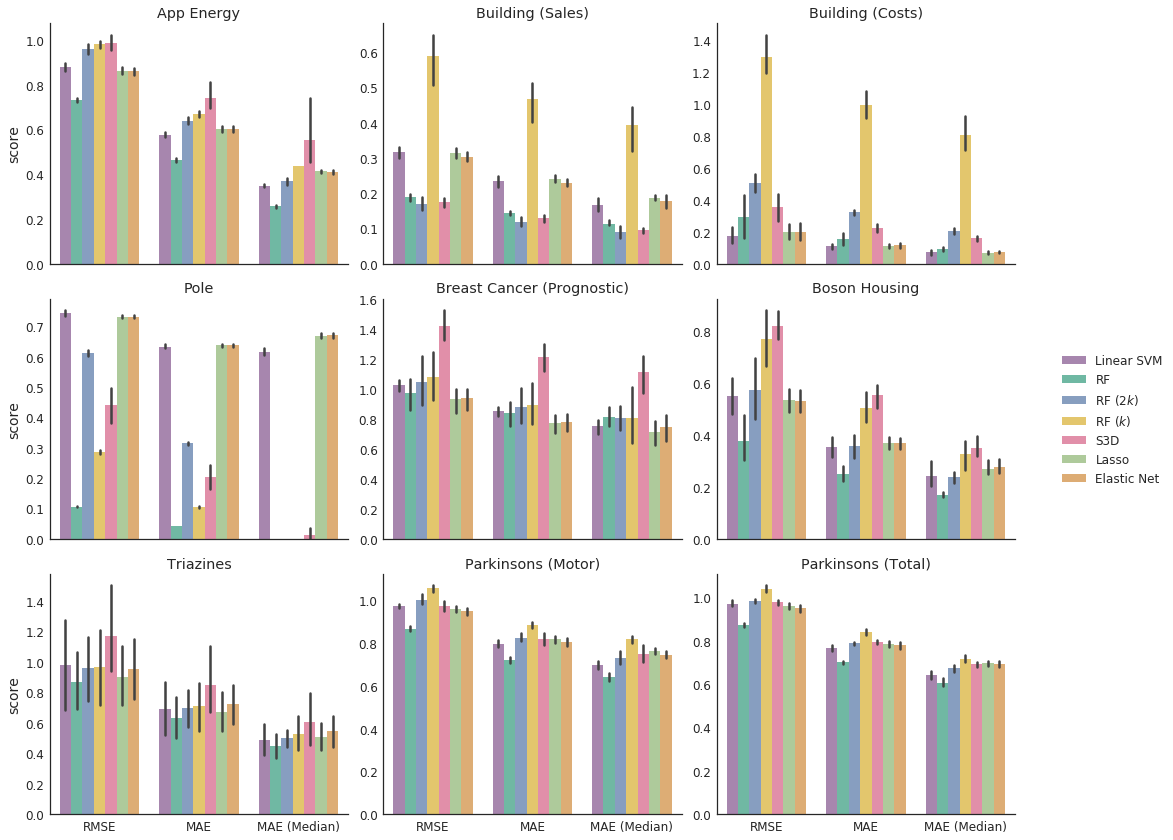

In [41]:
g, all_df = do_model_compare(data_list, metric_list, type_=type_,
                             bm_dir='{}/bm-performance/'.format(type_), 
                             s3d_dir='{}/performance/'.format(type_),
                             fp_kwargs=fp_kwargs,
                            )
g.set_xticklabels(['RMSE', 'MAE', 'MAE (Median)'])
for i, t in enumerate(g._legend.texts):
    t.set_text(legend_text[i])
for ax_i in g.axes:
    ax_i.set_title(name_pair_dict[ax_i.get_title()])